作成：2025_Aug_12、更新：2025_Aug_12、by Nobuyuki Shigeeda
## はじめに<br>
### このコードの目的
 - このコードは、気象庁数値予報計算で使用される地理データを取得し、DataArray化することで、気象要素の可視化で標高など地理データをレンダリングできるようにするスクリプトである。
### 使用方法
 - 可視化で使用する地理データを設定して本スクリプトを実行する。
 - 地理データの種類によって格子数や格子間隔が異なるため、Readmeに記載されている仕様に合わせてスクリプトを修正する必要がある。
### 使用するデータ
地理データは、次のサイトから取得する。
 -  京都大学生存圏データベース <br> https://database.rish.kyoto-u.ac.jp/arch/jmadata/data/gpv/original/etc/
### データソース諸元
 - モデル毎のファイルと仕様 <br> https://database.rish.kyoto-u.ac.jp/arch/jmadata/data/gpv/original/etc/README%ef%bc%88%e6%94%af%e6%8f%b4%e3%82%bb%e3%83%b3%e3%82%bf%e3%83%bc%ef%bc%89_201406.txt
 - MSM LFM 用の標高データは、README（支援センター）_201702.txt　に仕様の記載がある。<br> https://database.rish.kyoto-u.ac.jp/arch/jmadata/data/gpv/original/etc/README%ef%bc%88%e6%94%af%e6%8f%b4%e3%82%bb%e3%83%b3%e3%82%bf%e3%83%bc%ef%bc%89_201702.txt
### 謝辞及び免責
本コードによって作成した図は、正確性・完全性を保証するものではございません。また本コードの利用に際しては、その利用方法に応じて著作権やその他の知的財産権を侵害しないことを確認のうえご利用ください。当方はこれに起因する損害について一切の責任を負いません。

----

# （スクリプトはここから）

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import urllib.request
#
from metpy.units import units
from metpy.calc import height_to_pressure_std
#
import matplotlib.pyplot as plt
#

## # 1. 地形データの取得と読み込み

In [ ]:
# --------------------------
# 1. 地形データの取得と読み込み
# --------------------------
# 
terrain_url = "https://database.rish.kyoto-u.ac.jp/arch/jmadata/data/gpv/original/etc"
#
# ★ダウンロードする地形データを設定する ★
# local_file = "TOPO.GL2.5_K8"
file_nm = "TOPO.MSM_5K"  # メソ数値予報モデルGPV用
#
path = './data/' # ファイル保存用パスの指定
#
dl_path = terrain_url + '/' + file_nm
urllib.request.urlretrieve(dl_path, path+file_nm)
#
data = np.fromfile(path+file_nm, dtype=">f4")
print(file_nm,'->', data.size)
#

TOPO.MSM_5K -> 242905


## # 2. 地形データと緯度経度を配列にする

In [ ]:
# --------------------------
# 2. 地形データと緯度経度を配列にする
# --------------------------
# 
##! ★ 地形データの仕様に合わせて以下を修正すること！
## TOPO.MSM_5K メソ数値予報モデルGPV用
lonlat_delta_x,lonlat_delta_y = 0.0625, 0.05 # 格子間隔：東西方向 0.0625度  南北方向 0.05度
nx, ny = 481, 505  # 格子数：東西方向 481  南北方向 505
init_lat, init_lon = 47.6, 120  # 先頭の格子点：北緯47.6度  東経120度
## TOPO.GL2.5_K8 用
# lonlat_delta = 2.5  # 格子間隔：2.5度（東西，南北両方向とも） 
# nx, ny = 144, 73  # 格子数：東西方向144(経度方向)  南北方向73(緯度方向)
# init_lat, init_lon = 90, 0  # 先頭の格子点：北緯90度  東経0度
#
#
# 先頭の格子点：北緯90度  経度0度
# 先頭の格子点から緯度の同じ格子点を経度方向東向きに格納し、そのすぐ南の緯度で同様に繰り返し格納しています。
topo_z = np.zeros([ny,nx])
# 緯度・経度 配列（lat,lon）順
lon2d, lat2d = np.zeros([ny, nx]), np.zeros([ny,nx])
#
# 格子点の標高(m)を取得
z=0
for y in range(ny): # 緯度方向
    for x in range(nx): # 経度方向
        topo_z[y,x] = data[z]
        z += 1
# 頂点座標の計算
lon_1d = init_lon + lonlat_delta_x * np.arange(nx)
lat_1d = init_lat - lonlat_delta_y * np.arange(ny)
#
# 標準大気圧（気圧）に変換
topo_p = height_to_pressure_std(topo_z*units("m"))
#

## # 3. 標高データと緯度経度をDataArrayにする

In [13]:
# --------------------------
# 3. 標高データと緯度経度をDataArrayにする
# --------------------------
# 
from pint import UnitRegistry
units = UnitRegistry()

# topo_p は pint.Quantity の場合は値のみ抽出
if hasattr(topo_p, 'magnitude'):
    topo_p_data = topo_p.magnitude
else:
    topo_p_data = topo_p

topo_p_xr = xr.DataArray(
    data=topo_p_data,
    dims=["lat", "lon"],
    coords={
        "lat": lat_1d,
        "lon": lon_1d,
    },
    attrs={
        "units": "hPa",
        "description": "Standard atmosphere pressure calculated from topography"
    }
)
#

In [14]:
# test code
topo_p_xr

<xarray.DataArray (lat: 505, lon: 481)> Size: 2MB
array([[ 878.31718005,  875.56313732,  875.19884619, ..., 1013.25      ,
        1013.25      , 1013.25      ],
       [ 877.6242316 ,  875.64833007,  875.94482971, ..., 1013.25      ,
        1013.25      , 1013.25      ],
       [ 879.67106404,  879.10062628,  879.81547071, ..., 1013.25      ,
        1013.25      , 1013.25      ],
       ...,
       [1013.25      , 1013.25      , 1013.25      , ..., 1013.25      ,
        1013.25      , 1013.25      ],
       [1013.25      , 1013.25      , 1013.25      , ..., 1013.25      ,
        1013.25      , 1013.25      ],
       [1013.25      , 1013.25      , 1013.25      , ..., 1013.25      ,
        1013.25      , 1013.25      ]])
Coordinates:
  * lat      (lat) float64 4kB 47.6 47.55 47.5 47.45 ... 22.55 22.5 22.45 22.4
  * lon      (lon) float64 4kB 120.0 120.1 120.1 120.2 ... 149.9 149.9 150.0
Attributes:
    units:        hPa
    description:  Standard atmosphere pressure calculated from topography

## # 4. DataArrayをnetCDF形式で保存する

In [15]:
# --------------------------
# 4. DataArrayをnetCDF形式で保存する
# --------------------------
# 
# netcdf 形式で保存する
file_nm_nc = file_nm + '.nc'
topo_p_xr.to_netcdf(path+file_nm_nc)


----

## 鉛直断面図に標高データを描画する（サンプルコード）

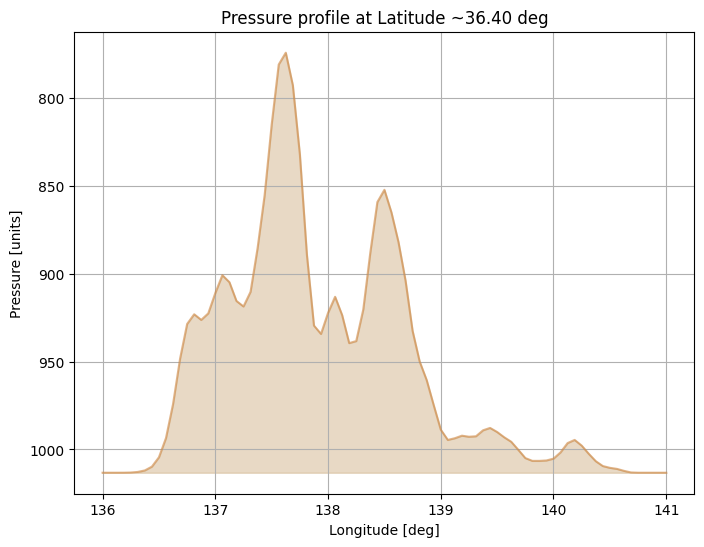

In [16]:
# 緯度の断面を取りたい値（例：43.0度）
target_lat = 36.4
# 経度軸範囲指定
lon_min, lon_max = 136, 141

# 緯度・経度を1次元化（経度方向に平均して1次元化）
lon_1d = topo_p_xr.lon.values
lat_1d = topo_p_xr.lat.values

# target_latに最も近い緯度インデックスを探す
idx_lat = np.abs(lat_1d - target_lat).argmin()
##
# 経度の範囲にあるインデックスを取得
idx_lon_range = np.where((lon_1d >= lon_min) & (lon_1d <= lon_max))[0]
# 経度範囲内の気圧データをスライス
profile = topo_p_xr.isel(lat=idx_lat).isel(lon=idx_lon_range)
# 経度範囲内の経度値
lon_vals = lon_1d[idx_lon_range]
#
# 描画
plt.figure(figsize=(8,6))
plt.fill_between(lon_vals, profile, profile.max(), color="tan", alpha=0.5)
plt.plot(lon_vals, profile, color="peru", alpha=0.6)  # プロファイル線も重ねる

plt.xlabel("Longitude [deg]")
plt.ylabel("Pressure [units]")
plt.title(f"Pressure profile at Latitude ~{lat_1d[idx_lat]:.2f} deg")
plt.gca().invert_yaxis()  # 気圧軸反転
plt.grid()
plt.show()
##

## 標高データを分布図として描画する（サンプルコード）

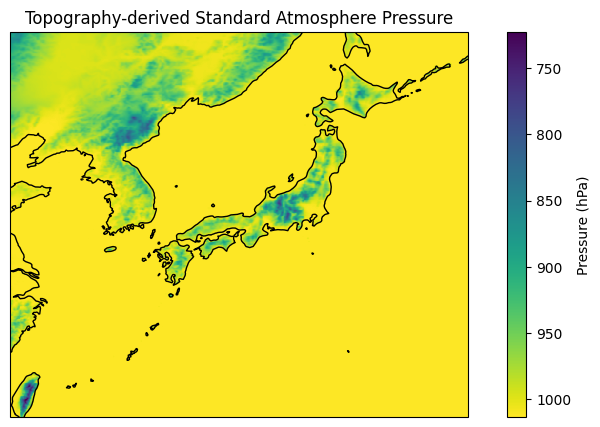

In [17]:
import cartopy.crs as ccrs
#
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 5))
#
im = topo_p_xr.plot(
    x="lon",
    y="lat",
    cmap="viridis",
    cbar_kwargs={"label": "Pressure (hPa)"}
)
im.colorbar.ax.invert_yaxis()
ax.coastlines(resolution='50m', color='black', linewidth=1)
plt.title("Topography-derived Standard Atmosphere Pressure")
plt.show()
#

----

# EOF